<font size = "5"> **Day 3: [Energy Dispersive X-Ray Spectroscopy, Principal Component Analysis, and Non-
Negative Matrix Factorization](../MLSTEM2024.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

[Download](https://raw.githubusercontent.com/gduscher/MLSTEM2024//main/Day3/5_Introduction_Core_Loss.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MLSTEM2024/blob/main/Day3/5_Introduction_Core_Loss.ipynb)


# Introduction to Core-Loss Spectra with Drude Theory

Lecturer: Gerd Duscher

part of the workshop of 

<font size = "5"> **[Machine Learning in Scanning Transmission Electron Microscopy](../_MLSTEM.ipynb)**</font>


**Day3: Energy Dispersive X-Ray Spectroscopy, Principal Component Analysis, and Non-
Negative Matrix Factorization**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**June 2024**

## Overview
We explore all the different contributions to an EDS spectrum 

This is a prerequisite for identifying and analyzing EDS spectra.


## Load packages
### Check for Newest Versions


In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.2.3':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q

print('done')

installing pyTEMlib
done


### Import all relevant libraries

Please note that the EELS_tools package from pyTEMlib is essential.

In [1]:
import sys
%matplotlib ipympl
if 'google.colab' in sys.modules:    
    from google.colab import output
    from google.colab import drive
    output.enable_custom_widget_manager()
    
import matplotlib.pylab as plt
import numpy as np

## We need to import a few important additional function from matplotlib, 
## because we want to demonstrate a few more hidden functionalities of the EELS_tools of pytTEMlib.
from matplotlib.widgets import Cursor
from matplotlib.patches import Rectangle
from matplotlib.widgets import SpanSelector

from scipy.ndimage import gaussian_filter

import sys
sys.path.insert(0, '../../pyTEMlib')

%load_ext autoreload
%autoreload 2
    
## import the configuration files of pyTEMlib (we need access to the data folder)
import pyTEMlib
import pyTEMlib.eels_tools as eels
import pyTEMlib.eels_dialog_utilities as ieels
from pyTEMlib import file_tools

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
pyTEM version:  0.2024.05.0


## Core --Loss Spectroscopy

As we can see in figure below the energies of the core shells are well defined and can be viewed as delta functions, unlike in the low loss region where the broad valence bands are the initial state. In both cases, however, we excite electrons into the conduction band.

<img title="core-loss" width="50%" alt="core-loss" src="images/core-loss.jpg">
*Excitation from a core-shell state up into the conduction band above the Fermi level.*

If we look at the transition between two states $< \Phi_f | H | \Phi_i >$ the transition should be quite sharp. In the case of the low-loss spectrum, we have many initial (the valence) states and many final (the conduction) states. The spectrum will be a convolution of these states. 

The features of the core--loss edges are, therefore, much sharper than any details in the low--loss region. Because only the final states contribute to the features. These sharp features enable a wide variety of analysis to determine the chemical compositions and chemical bonding, probing the local conduction band of the sample.



### Chemical Composition

In this chapter we use the area under the ionization edge to determine the chemical composition of a (small) sample volume. 
The equation used to determine the number of atoms per unit volume $N$ (also called areal density) is:
\begin{equation}
I_{edge}(\beta, \Delta E) = N I_{0}(\beta) \sigma_{edge}(\beta, \Delta E)
\end{equation}

$I_0$ is the number of electrons hitting the sample, and so directly comparable to the beam current.

The equation can be approximated assuming that the spectrum has not been corrected for single scattering:
\begin{equation} 
I_{edge}(\beta, \Delta E) = N I_{low-loss}(\beta,\Delta E) \sigma_{edge}(\beta, \Delta E)
\end{equation}
where $\beta$ is the collection angle and $\sigma_{edge}$ is the **partial** cross--section (for energy window $\Delta E$) for the core--loss excitation.


> 
> It is this cross-section $ \sigma_{edge}$ that we want to explorein this notebook.
>
We will use this cross-section and the background to determine the chemical composition of a spectrum.

We will use a dashboard notebook for analysis in this notebook.


## Load Cross-Sections


The form factors are from:
X-Ray Form Factor, Attenuation, and Scattering Tables
NIST Standard Reference Database 66

 DOI: https://dx.doi.org/10.18434/T4HS32

Detailed Tabulation of Atomic Form Factors, Photoelectric Absorption and Scattering Cross Section, and Mass Attenuation Coefficients for Z = 1-92 from E = 1-10 eV to E = 0.4-1.0 MeV
C.T. Chantler,1 K. Olsen, R.A. Dragoset, J. Chang, A.R. Kishore, S.A. Kotochigova, and D.S. Zucker
NIST, Physical Measurement Laboratory

The cross sections are part of the pyTEMlib package and are stored as a pickled dictionary in the package data directory.

Below are the lines for accessing the cross sections with eels_tools of pyTEMlib.

In [2]:
Xsections = eels.get_x_sections()

## Plot Cross Sections

Please add your favourite element ot the list of atomic numbers.

With the code cell above we made the whole database of cross secitons available for this notebook.

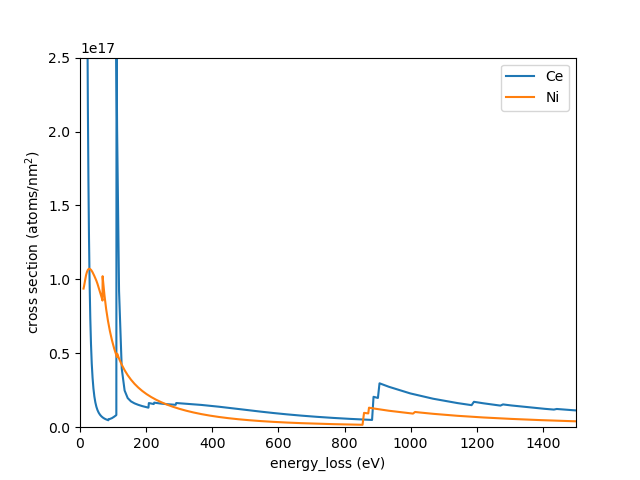

In [3]:
# -----Input ------------ #
atomic_numbers = [58, 28]
# ----------------------- #
fig, ax = plt.subplots()
for Z in atomic_numbers:
    ax.plot(Xsections[str(Z)]['ene'], Xsections[str(Z)]['dat'], label = Xsections[str(Z)]['name'])

ax.set_xlim(0,1500)
ax.set_ylim(0,2.5e17)
ax.set_xlabel('energy_loss (eV)')
ax.set_ylabel('cross section (atoms/nm$^2$)')
plt.legend();

### List All Edges of an Element 

In [4]:
element = str(58)
for key in Xsections[element]:
    if isinstance(Xsections[element][key], dict):
        if 'onset' in Xsections[element][key]:
            print(f"{Xsections[element]['name']}-{key}: {Xsections[element][key]['onset']:8.1f} eV ")
            


Ce-O3:     19.8 eV 
Ce-O2:     19.8 eV 
Ce-O1:     37.8 eV 
Ce-N6:     85.9 eV 
Ce-N5:    110.0 eV 
Ce-N4:    110.0 eV 
Ce-N3:    207.2 eV 
Ce-N2:    223.3 eV 
Ce-N1:    289.6 eV 
Ce-M5:    883.3 eV 
Ce-M4:    901.3 eV 
Ce-M3:   1185.4 eV 
Ce-M2:   1272.8 eV 
Ce-M1:   1434.6 eV 
Ce-L3:   5723.4 eV 
Ce-L2:   6164.2 eV 
Ce-L1:   6548.8 eV 
Ce-K1:  40443.0 eV 


Or ordered

In [5]:
major_edges = ['K1', 'L3', 'M5', 'N5']
all_edges = ['K1','L1','L2','L3','M1','M2','M3','M4','M5','N1', 'N2','N3','N4','N5','N6','N7','O1','O2','O3','O4','O5','O6','O7', 'P1', 'P2', 'P3']
first_close_edges = ['K1', 'L3', 'M5', 'M3', 'N5', 'N3']

element = str(28)

def list_all_edges(Z):
    element = str(Z)
    print('All edges')
    for key in all_edges:
        if key in Xsections[element]:
            if 'onset' in Xsections[element][key]:
                print(f" {Xsections[element]['name']}-{key}: {Xsections[element][key]['onset']:8.1f} eV ")

def list_major_edges(Z):
    element = str(Z)
    print('Major edges')
    for key in major_edges:
        if key in Xsections[element]:
            if 'onset' in Xsections[element][key]:
                print(f" {Xsections[element]['name']}-{key}: {Xsections[element][key]['onset']:8.1f} eV ")                      
## Here with the function of the EELS_tools package                      
list_all_edges(element)
list_major_edges(element)

All edges
 Ni-K1:   8332.8 eV 
 Ni-L1:   1008.1 eV 
 Ni-L2:    871.9 eV 
 Ni-L3:    854.7 eV 
 Ni-M1:    111.8 eV 
 Ni-M2:     68.1 eV 
 Ni-M3:     68.1 eV 
 Ni-M4:      3.6 eV 
 Ni-M5:      3.6 eV 
Major edges
 Ni-K1:   8332.8 eV 
 Ni-L3:    854.7 eV 
 Ni-M5:      3.6 eV 


### Plotting all edges of an element in view

Now, let's do it graphically

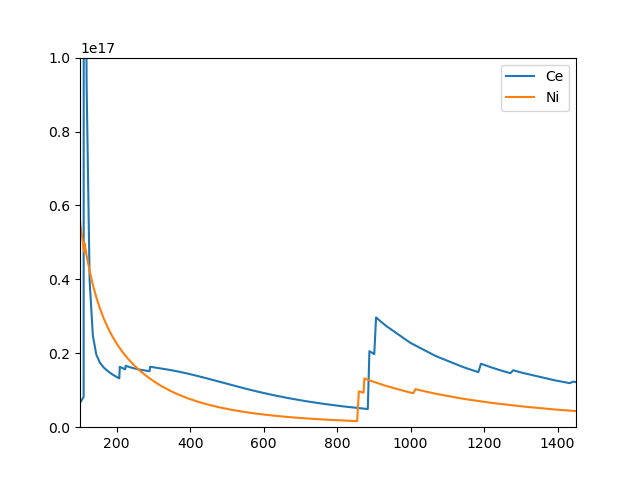

In [6]:
major_edges = ['K1', 'L3', 'M5', 'N5']
all_edges = ['K1','L1','L2','L3','M1','M2','M3','M4','M5','N1', 'N2','N3','N4','N5','N6','N7','O1','O2','O3','O4','O5','O6','O7', 'P1', 'P2', 'P3']
first_close_edges = ['K1', 'L3', 'M5', 'M3', 'N5', 'N3']

def get_Z(Z):
    """
    returns the atomic number independent of input as a string or number
    
    input:
    Z: atomic number of chemical symbol (0 if not valid)
    """
    Xsections = eels.get_x_sections()
    
    Z_out = 0
    if str(Z).isdigit(): 
        Z_out = Z
    elif isinstance(Z, str):
        for key in Xsections:
            if Xsections[key]['name'].lower() == Z.lower(): ## Well one really should know how to write elemental 
                Z_out = int(key)
    return Z_out


class ElementalEdges(object):
    def __init__(self, ax, Z):
        self.ax = ax
        self.labels = None
        self.lines = None
        
        self.Z = get_Z(Z)
        self.color = 'black'
        self.Xsections = eels.get_x_sections()
        self.cid = ax.figure.canvas.mpl_connect('draw_event', self.onresize)
        
        #self.update()
    def set_edge(self,Z):
        self.Z = get_Z(Z)
        
            
        self.update()
    def onresize(self, event):
        self.update()
        
    def update(self):
        
        if self.labels != None:
            for label in self.labels:
                label.remove()
        if self.lines != None:
            for line in self.lines:
                line.remove()
        if self.Z>0:
            self.labels = [] ; self.lines =[] 
            x_min, x_max = self.ax.get_xlim()
            y_min, y_max = self.ax.get_ylim()
            x_bounds = ax.get_xlim()
            element = str(self.Z)
            Xsections = self.Xsections
            for key in all_edges:
                if key in Xsections[element]:
                    if 'onset' in Xsections[element][key]:
                        x = Xsections[element][key]['onset']
                        if x > x_min and x < x_max:
                            if key in first_close_edges:
                                label2 = self.ax.text(x, y_max,f"{Xsections[element]['name']}-{key}",
                                                      verticalalignment='top', rotation = 0, color = self.color)
                            else:
                                label2 = self.ax.text(x, y_max,f"\n{Xsections[element]['name']}-{key}",
                                                      verticalalignment='top', color = self.color)
                            line2 = self.ax.axvline(x,ymin = 0,ymax = 1,color=self.color)

                            self.labels.append(label2)

                            self.lines.append(line2)
                    
        
    def disconnect(self):
        if self.labels != None:
            for label in self.labels:
                label.remove()
        if self.lines != None:
            for line in self.lines:
                line.remove()
        self.labels = None
        self.lines = None
        self.ax.figure.canvas.mpl_disconnect(self.cid)
    def reconnect(self):    
        self.cid = ax.figure.canvas.mpl_connect('draw_event', self.onresize)
        ax.figure.canvas.draw_idle()
        
fig, ax_Xsec = plt.subplots()                
for Z in atomic_numbers:
    ax_Xsec.plot(Xsections[str(Z)]['ene'], Xsections[str(Z)]['dat'], label = Xsections[str(Z)]['name'])
ax_Xsec.set_xlim(100,1450)
ax_Xsec.set_ylim(0,1e17)
plt.legend();   
Z = 58
edges = ElementalEdges(ax_Xsec, 'Ce')


Let's make the lines disappear

In [7]:
edges.disconnect()

and reappear in the plot above

In [8]:
edges.set_edge(Z)

Let's set another edge

In [ ]:
edges.set_edge(28)

### Find Edges Listed in Xsection Dictionary

please note that the two functions below are as ususal available in the EELS_tools of pyTEMlib

In [10]:
# --- Input ----
edge_onset = 284
maximal_chemical_shift = 7
# -------------
print(f'Major Edges within {maximal_chemical_shift:.1f} eV of {edge_onset:.1f}')
print(eels.find_all_edges(edge_onset, maximal_chemical_shift, major_edges_only=True))
print(f'\nAll Edges within {maximal_chemical_shift:.1f} eV of {edge_onset:.1f}')
print(eels.find_all_edges(edge_onset, maximal_chemical_shift))

Major Edges within 7.0 eV of 284.0

 C -K1:    283.8 eV 
 Ru-M5:    279.4 eV 

All Edges within 7.0 eV of 284.0

 C -K1:    283.8 eV 
 Kr-M1:    288.3 eV 
 Sr-M2:    279.8 eV 
 Ru-M5:    279.4 eV 
 Ru-M4:    283.6 eV 
 Ce-N1:    289.6 eV 
 Eu-N2:    283.9 eV 
 Gd-N2:    288.5 eV 
 Tb-N3:    285.0 eV 
 Os-N4:    289.4 eV 


### Find Edges Depending on Cursor Postion

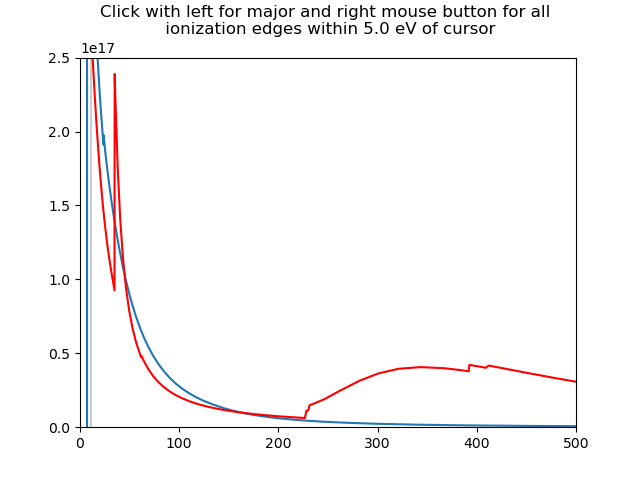

In [11]:
# We are using 
# from matplotlib.widgets import Cursor

maximal_chemical_shift = 5
fig, ax = plt.subplots()
plt.title(f'Click with left for major and right mouse button for all \n ionization edges within {maximal_chemical_shift:.1f} eV of cursor')
maximal_chemical_shift = 5
cursor = ieels.EdgesAtCursor(ax, Xsections['42']['ene'], Xsections['42']['dat'],maximal_chemical_shift)
cursor.maximal_chemical_shift =maximal_chemical_shift
cid =  plt.connect('motion_notify_event', cursor.mouse_move)

ax.plot(Xsections['16']['ene'], Xsections['16']['dat']*2, label = 'S')
ax.plot(Xsections['42']['ene'], Xsections['42']['dat'], 'r', label = 'Mo')
ax.set_xlim(0,500)
ax.set_ylim(0,2.5e17);




## EELS cross sections
### Determine Effective Collection Angle

EELS cross sections are dependent on the momentum transfer (angle dependence), while photons cannot transfer any momentum. The angle dependence is given by the experimental set-up and can be calculated by the convolution of collection and convergence angle.

Here we use the method of [Pierre Trebbia, Ultramicroscopy **24** (1988) pp.399-408](https://doi.org/10.1016/0304-3991(88)90130-1)


In [12]:
def effective_collection_angle(ene,  alpha, beta, beam_kv):
    """ effective collection angle for convergent beam setup
    
    
    
    Original abstract of function y = effbeta(ene,  alpha, beta, beamkV)
    # 
    #       This program computes etha(alpha,beta), that is the collection
    #       efficiency associated to the following geometry :
    #
    #       alpha = half angle of illumination  (0 -> pi/2)
    #       beta  = half angle of collection    (0 -> pi/2)
    #                                           (pi/2 = 1570.795 mrad)
    #
    #           A constant angular distribution of incident electrons is assumed
    #       for any incident angle (-alpha,alpha). These electrons impige the
    #       target and a single energy loss event occurs, with a characteristic
    #       angle theta-e (relativistic). The angular distribution of the
    #       electrons after the target is analytically derived.
    #           This program integrates this distribution from theta=0 up to
    #       theta=beta with an adjustable angular step.
    #           This program also computes beta* which is the theoretical
    #       collection angle which would give the same value of etha(alpha,beta)
    #       with a parallel incident beam.
    #
    #       subroutines and function subprograms required
    #       ---------------------------------------------
    #       none
    #
    #       comments
    #       --------
    #
    #       The following parameters are asked as input :
    #        accelerating voltage (kV), energy loss range (eV) for the study,
    #        energy loss step (eV) in this range, alpha (mrad), beta (mrad).
    #       The program returns for each energy loss step :
    #        alpha (mrad), beta (mrad), theta-e (relativistic) (mrad),
    #        energy loss (eV), etha (#), beta * (mrad)
    #
    #       author :
    #       --------
    #       Pierre TREBBIA
    #       US 41 : "Microscopie Electronique Analytique Quantitative"
    #       Laboratoire de Physique des Solides, Bat. 510
    #       Universite Paris-Sud, F91405 ORSAY Cedex
    #       Phone : (33-1) 69 41 53 68
    #
    #       
    """
        
       
    z1 = beam_kv*1000.  ;   # eV
    z2 = ene[0];
    z3 = ene[-1]
    z4 = 100.0
    z5 = alpha*0.001   # rad
    z6 = beta*0.001    # rad
    z7 = 500          # number of integration steps to be modified at will

    # main loop on energy loss
    
    for  zx in range(int(z2),int(z3),int(z4)): #! zx = current energy loss
        eta=0.0;
        x0=float(zx)*(z1+511060.)/(z1*(z1+1022120.));  # x0 = relativistic theta-e
        x1 = np.pi/(2.*x0);
        x2=x0*x0+z5*z5;
        x3=z5/x0*z5/x0;
        x4=0.1*np.sqrt(x2);
        dtheta=(z6-x4)/z7;
        #
        # calculation of the analytical expression
        #
        for zi in range(1, int(z7)):
            theta=x4+dtheta*float(zi);
            x5=theta*theta;
            x6=4.*x5*x0*x0;
            x7=x2-x5;
            x8=np.sqrt(x7*x7+x6);
            x9=(x8+x7)/(2.*x0*x0);
            x10=2.*theta*dtheta*np.log(x9);
            eta=eta+x10;
    
              
    
        eta=eta+x2/100.*np.log(1.+x3)   ;  # addition of the central contribution
        x4=z5*z5*np.log(1.+x1*x1);         # normalisation
        eta=eta/x4;
        #
        #        correction by geometrical factor (beta/alpha)**2
        #
        if (z6<z5):
            x5=z5/z6;
            eta=eta*x5*x5;
    
        etha2=eta*100.;
        #
        #        calculation of beta *
        #
        x6=np.power((1.+x1*x1),eta);
        x7=x0*np.sqrt(x6-1.);
        y=x7*1000.;

    
    return y

    

In [38]:
energy_scale = np.linspace(100,500,1000)
alpha=30 
beta=20
eff_beta = effective_collection_angle(energy_scale,  alpha=alpha, beta=beta, beam_kv=200)
print(f'Convergence angle  {alpha:.2f} mrad and collection angle {beta:.2f} mrad \n '
      f'results in effective collection angle of is {eff_beta:.2f} mrad')

Convergence angle  30.00 mrad and collection angle 20.00 mrad 
 results in effective collection angle of is 26.13 mrad


### Calculating EELS Cross Section

EELS cross sections are dependent on the momentum transfer (angle dependence), while photons cannot transfer any momentum. The angle dependence of the cross-section is aproximated by the equation 4 in:
[Egerton Ultramicroscopy 50 (1993) 13-28](https://doi.org/10.1016/0304-3991(93)90087-E)

The units of atom density in  electron microscopy is atoms per nm$^2$.
Cross sections are normally given in barns (a neutron scattering joke).

A barn is 10$^{-28}$ m$^2$ which is then 1 barn = 10$^{-10}$ nm$^2$

Therefore, to get a probability per nm$^2$ we have to divide the cross-section in barns by 10$^{10}$

𝐼𝑒𝑑𝑔𝑒(𝛽,Δ𝐸)=𝑁𝐼𝑙𝑜𝑤−𝑙𝑜𝑠𝑠(𝛽,Δ𝐸)𝜎𝑒𝑑𝑔𝑒(𝛽,Δ𝐸)


In [14]:

from scipy.interpolate import splev,splrep,splint
#from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import leastsq

def xsec_xrpa(energy_scale, E0, Z, beta, shift=0 ):
    """
    Calculate momentum-integrated cross-section for EELS from X-ray photoaborption  cross-sections.
    
    Input:
    ------
    energy_scale: energyscale of spectrum to be analyzed
    E0: acceleration voltage in keV
    Z: atomic number of element
    beta: effective collection angle in mrad
    shift: chemical shift of edge in eV
    """
 
    beta = beta * 0.001;     #% collection half angle theta [rad]
    #thetamax = self.parent.spec[0].convAngle * 0.001;  #% collection half angle theta [rad]
    dispersion = energy_scale[1]-energy_scale[0]
    
    Xsections = eels.get_Xsections(Z)
    enexs = Xsections['ene']
    datxs = Xsections['dat']
        
    #####
    ## Cross Section according to Egerton Ultramicroscopy 50 (1993) 13-28 equation (4)
    #####

    # Relativistic correction factors
    T = 511060.0*(1.0-1.0/(1.0+E0/(511.06))**2)/2.0;
    gamma=1+E0/511.06;
    A = 6.5#e-14 *10**14
    b = beta

    thetaE = enexs/(2*gamma*T)

    G = 2*np.log(gamma)-np.log((b**2+thetaE**2)/(b**2+thetaE**2/gamma**2))-(gamma-1)*b**2/(b**2+thetaE**2/gamma**2)
    datxs = datxs*(A/enexs/T)*(np.log(1+b**2/thetaE**2)+G)/1e8

    datxs = datxs * dispersion # from per eV to per dispersion
    coeff = splrep(enexs,datxs,s=0) # now in areal density atoms / m^2
    xsec = np.zeros(len(energy_scale ))
    #shift = 0# int(ek -onsetXRPS)#/dispersion
    lin = interp1d(enexs,datxs,kind='linear') # Linear instead of spline interpolation to avoid oscillations.
    xsec = lin(energy_scale-shift)
    
    return xsec
energy_scale = np.arange(100,600)
B_Xsection = eels.xsec_xrpa(energy_scale, 200, 5,  10. )/1e10  
N_Xsection = eels.xsec_xrpa(energy_scale, 200, 7,  10. )/1e10       #  xsec  is in barns = 10^28 m2 = 10^10 nm2


### Plotting of Cross Sections
please note that spectrum and cross sections are not on the same scale

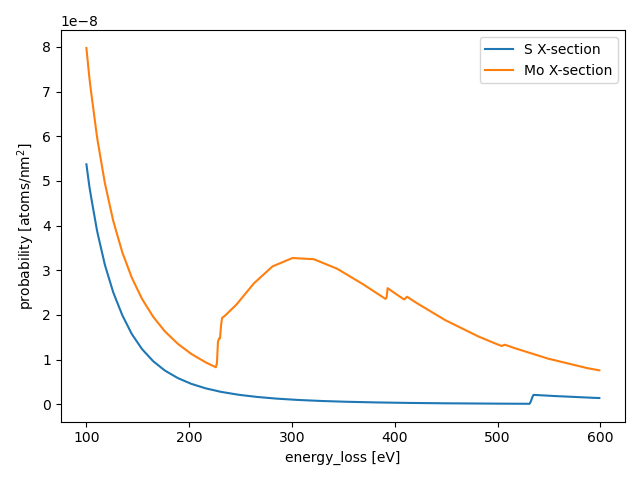

In [15]:
S_Xsection  = eels.xsec_xrpa(energy_scale, 200, 16, 10. )/1e10  
Mo_Xsection = eels.xsec_xrpa(energy_scale, 200, 42, 10. ,shift=0)/1e10       #  xsec  is in barns = 10^28 m2 = 10^10 nm2

fig, ax1 = plt.subplots()

ax1.plot(energy_scale, S_Xsection, label='S X-section' )
ax1.plot(energy_scale, Mo_Xsection, label='Mo X-section' )
ax1.set_xlabel('energy_loss [eV]')
ax1.set_ylabel('probability [atoms/nm$^{2}$]')


plt.legend();
fig.tight_layout();

## Chemical Composition


We discuss first the conventional method of EELS chemical compoisition determination


In this chapter we use the area under the ionization edge to determine the chemical composition of a (small) sample volume. 
The equation used to determine the number of atoms per unit volume $N$ (also called areal density) is:
\begin{equation}
I_{edge}(\beta, \Delta E) = N * I_{0}(\beta) * \sigma_{edge}(\beta, \Delta E)
\end{equation}

$I_0$ is the number of electrons hitting the sample, and so directly comparable to the beam current.

The equation can be approximated assuming that the spectrum has not been corrected for single scattering:
\begin{equation} 
I_{edge}(\beta, \Delta E) = N * I_{low-loss}(\beta,\Delta E) *  \sigma_{edge}(\beta, \Delta E)
\end{equation}
where $\beta$ is the collection angle and $\sigma_{edge}$ is the **partial** cross--section (for energy window $\Delta E$) for the core--loss excitation.

The integration interval $\Delta E$ which defines  $I_{edge}(\beta, \Delta E)$ and $I_{low-loss}$ is shown in figure below. 

<img title="chemical_composition" width="50%" alt="chemical_composition" src="images/edge2.jpg">

*Valence--loss, core--loss edges and background of SrTiO$_3$]{\label{fig:edge2} Ti-L$_{2,3}$ and O-K (right) core--loss edges and background of SrTiO$_3$. The valence-loss spectrum with the zero--loss $I_{zero-loss}$ and low--loss intensities $I_{low-loss} $ to be used in the quantification are displayed in the background.*

If we cannot determine the intensity of the zero-loss peak  $I_{zero-loss}$  or of the low-loss area $I_{low-loss}$, we still can determine relative chemical compositions of two elements $a$ and $b$ considering that:

\begin{equation}
\frac{N_a}{N_b} = \frac{I_{e_a}(\beta, \Delta E)}{I_0 \sigma_{e_a}(\beta, \Delta E)} \frac{I_0 \sigma_{e_b}(\beta, \Delta E) } {I_{e_b}(\beta, \Delta E)} \nonumber 
\end{equation}

\begin{equation}
\frac{N_a}{N_b}=  \frac{I_{e_a}(\beta, \Delta E)\sigma_{e_b}(\beta, \Delta E) } 
{I_{e_b}(\beta, \Delta E)\sigma_{e_a}(\beta, \Delta E) } 
\end{equation}

and the value $I_0$ cancels out.

The integration windows for the two edges $\Delta E$ should be the same, but can be chosen differently as long as we use a different cross-section $\sigma$ as well. For that case we get:

\begin{equation} \
\frac{N_a}{N_b} =  \frac{I_{e_a}(\beta, \Delta E_a)\sigma_{e_b}(\beta, \Delta E_b) } 
{I_{e_b}(\beta, \Delta E_a)\sigma_{e_a}(\beta, \Delta E_a) } 
\end{equation}

Note, that the use of different integration windows usually results in a larger error of the quantification.

In order to use the above equation we first  have to determine the background under the edge.
This background  is then subtracted from the spectrum.
Then we integrate over the different parts of the spectrum to determine the integrals (sums) of $I_{edge}$,  and $I_{zero-loss}$, or  $I_{low-loss} $ (depending whether we did a SSD first or not).
After that we have to determine the cross-section ([notebook](./CH4_07-Introduction_Core_Loss.ipynb)) for each edge for the parameter $\beta$ and $\Delta E$.

### Background Fitting

The core-loss edges occur usually at energy-losses higher than 100 eV, superimposed to a monotonic decreasing background. For quantification of the chemical composition we need the area under the edge of a spectrum, and therefore, need to subtract the intensity of the background under the edge. Here we discuss several methods of how to determine the intensity of the background under the  edge.

The high energy ``tail`` of the plasmon peak follows the power law $A E^{-r}$. The parameter is varies widely and is associated with the intensity of the background. $E$ is the energy loss. The exponent $r$ gives the slope and should be between 2-6. The value $r$ usually decreases with increasing specimen thickness, because of plural-scattering contributions. $r$ also decreases with increasing collection angles $\beta$, but increases with increasing energy--loss.


**Consequently, we have to determine the parameters $A$ and $r$ for each ionization edge.**


The fitting of the power law $A E^{-r}$ (to determine $A$ and $r$) is usually done in an area just before the edge, assuming that the background follows the same power law under the edge.
This fit can only work if the detector dark current and gain variation is corrected prior to the analysis.


A standard technique is to match the pre--edge background $J(E)$ to a function $F(E)$ (here the power law) whose parameter (here $A$ and $r$) minimize the quantity:
\begin{equation} 
\chi^2 = \sum \limits_{i} \left[  \frac{J_i - F_i}{\sigma_i} \right]^2
\end{equation}
where $i$ is the index of the channel within the fitting region and $\sigma_i$ represents the statistical error (standard deviation) of the intensity in that channel.

The value $\sigma_i$ is often considered constant (for example $1/3$ or $e^{-1}$). For our problem, the quantum mechanical shot noise is adequate 
\begin{equation} 
\sigma_i = \ln(J_i - \sqrt{J_i}) - \ln(J_i) \approx \sqrt{J_i} 
\end{equation}
where we assume that $J_i$ is in number of electrons and not in counts (number of electrons times a conversion factor).

In the figure below, we see the result and the output of the background fit (plus subtraction).

<img title="chemical_composition" width="50%" alt="chemical_composition" src="images/background.jpg">

* Background fit on a spectrum of SrTiO$_3$]{\label{fig:background} Background fit on a spectrum of SrTiO$_3$. The $A$ and $r$ parameter together with the normalized (reduced) $\chi^2_n$ parameter is displayed in the {\bf Results} window.*

## Quantifying a spectrum

### Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.


In [16]:
# ---- Input ------
load_example = True
# -----------------
if not load_example:
    if 'google.colab' in sys.modules:
        drive.mount("/content/drive")

    fileWidget = file_tools.FileWidget()

experiment :
	single_exposure_time : 3.0
	exposure_time : 63.0
	number_of_frames : 21
	collection_angle : 33.0
	convergence_angle : 30.0
	acceleration_voltage : 200000.0


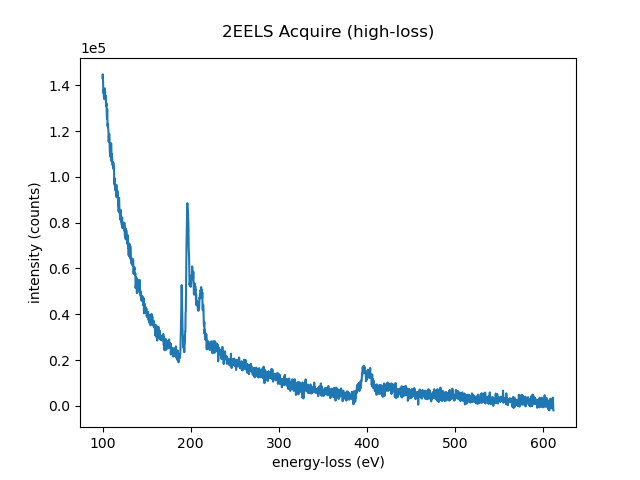

In [17]:
# ---- Input ------
load_example = True
file_name = '1EELS Acquire (high-loss).dm3'
# -----------------
if load_example:
    if 'google.colab' in sys.modules:
      if not os.path.exists('./'+file_name):
        !wget  https://github.com/gduscher/MSE672-Introduction-to-TEM/raw/main/example_data/1EELS Acquire (high-loss).dm3
    else:
        datasets = file_tools.open_file('../example_data/'+file_name)
        main_dataset = datasets['Channel_000']
      
else:
    datasets = fileWidget.datasets
    main_dataset = fileWidget.selected_dataset
    

if main_dataset.data_type.name != 'SPECTRUM':
    print('NOT what we want here')
else:
    main_dataset.view_metadata()

v = main_dataset.plot()

### Probability scale of y-axis

We need to know the total amount of electrons involved in the EELS spectrum 

There are three possibilities:
- the intensity of the low loss will give us the counts per acquisition time
- the intensity of the beam in an image
- a direct measurement of the incident beam current

Here we got the low-loss spectrum. For the example please load **1EELS Acquire (low-loss).dm3** from the *example data* folder.

In [18]:
# ---- Input ------
load_example = True
# -----------------
if not load_example:
    if 'google.colab' in sys.modules:
        drive.mount("/content/drive")

    ll_fileWidget = file_tools.FileWidget()

experiment :
	single_exposure_time : 0.01
	exposure_time : 0.21
	number_of_frames : 21
	collection_angle : 33.0
	convergence_angle : 30.0
	acceleration_voltage : 200000.0


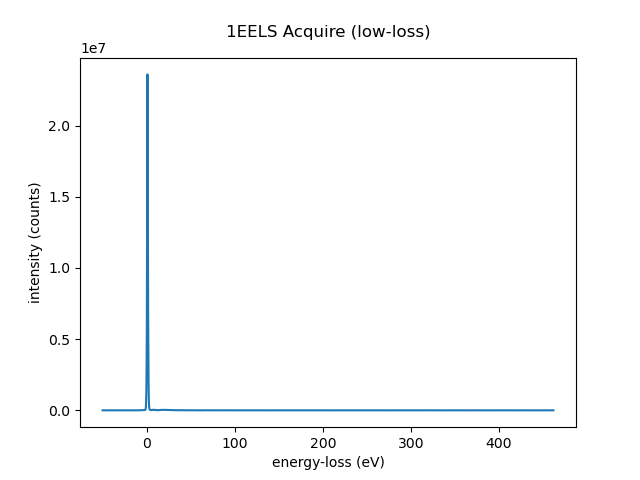

In [19]:
# ---- Input ------
load_example = True
ll_file_name = '1EELS Acquire (low-loss).dm3'
# -----------------
if load_example:
    if 'google.colab' in sys.modules:
      if not os.path.exists('./'+file_name):
        !wget  https://github.com/gduscher/MSE672-Introduction-to-TEM/raw/main/example_data/1EELS Acquire (low-loss).dm3
    else:
        ll_datasets = file_tools.open_file('../example_data/'+ll_file_name)
        ll_dataset = ll_datasets['Channel_000']
      
else:
    ll_datasets = ll_fileWidget.datasets
    ll_dataset = ll_fileWidget.selected_dataset


ll_dataset.view_metadata()

v = ll_dataset.plot()

### Intensity to Probability Calibration

 We need to calibrate the number of counts with the integration time of the spectrum.

incident beam current of core--loss spectrum is 34710045600 counts  in  0.21 sec


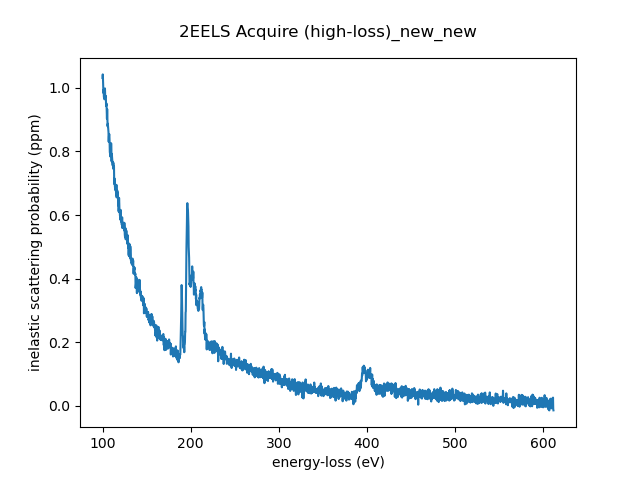

In [20]:

ll_dataset.metadata['experiment']['exposure_time'] = ll_dataset.metadata['experiment']['number_of_frames'] *ll_dataset.metadata['experiment']['single_exposure_time']
I0 = ll_dataset.sum()/ll_dataset.metadata['experiment']['exposure_time']*main_dataset.metadata['experiment']['exposure_time']

print(f"incident beam current of core--loss spectrum is {I0:.0f} counts  in  {ll_dataset.metadata['experiment']['exposure_time']:.2f} sec")

main_dataset.metadata['experiment']['intentsity_scale_ppm'] = 1/I0*1e6
main_dataset.metadata['experiment']['incident_beam_current_counts'] = I0

dispersion = main_dataset.energy_loss[1] - main_dataset.energy_loss[0]
spectrum = main_dataset *main_dataset.metadata['experiment']['intentsity_scale_ppm'] * dispersion
spectrum.quantity = 'inelastic scattering probability'
spectrum. units = 'ppm'
view =spectrum.plot()


In [21]:
channels = np.searchsorted(spectrum.energy_loss, [188, 388])
dE = (401-188)/ (channels[1]-channels[0])
dE , spectrum.energy_loss[1]- spectrum.energy_loss[0]

(0.26625, 0.25)

In [22]:
spectrum.energy_loss *= dE/(spectrum.energy_loss[1]- spectrum.energy_loss[0])

In [24]:
spectrum.energy_loss -= spectrum.energy_loss[channels[0]]-188

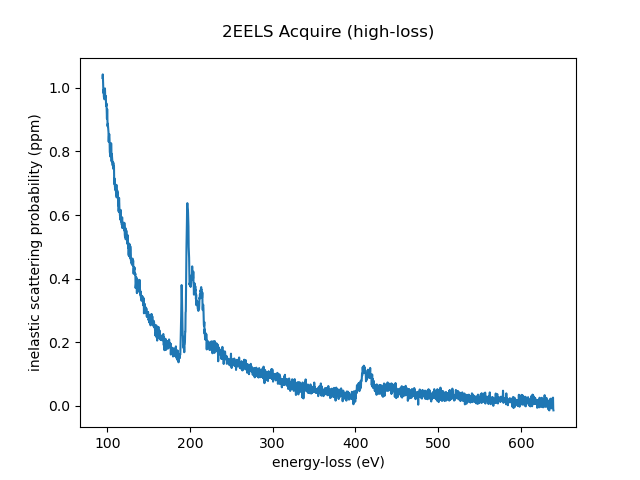

In [26]:
spectrum.title = main_dataset.title

v = spectrum.plot()

## Components of a core loss spectrum

-background

-absorption edges

### Plotting of cross sections and spectrum
please note that spectrum and cross sections are not on the same scale

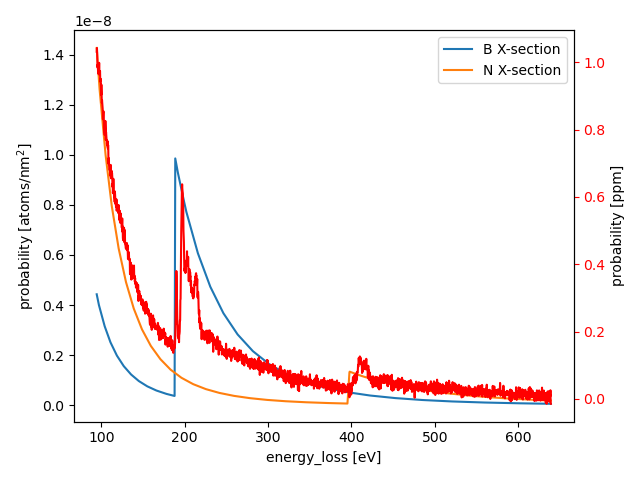

In [81]:
energy_scale = spectrum.energy_loss
B_Xsection = eels.xsec_xrpa(energy_scale, 60, 5, 10. )/1e10  
N_Xsection = eels.xsec_xrpa(energy_scale, 60, 7, 10. ,shift=-6)/1e10       #  xsec  is in barns = 10^28 m2 = 10^10 nm2

fig, ax1 = plt.subplots()

ax1.plot(energy_scale, B_Xsection, label='B X-section' )
ax1.plot(energy_scale, N_Xsection, label='N X-section' )
ax1.set_xlabel('energy_loss [eV]')
ax1.set_ylabel('probability [atoms/nm$^{2}$]')
plt.legend();
ax2 = ax1.twinx()
ax2.plot(energy_scale, spectrum, c='r', label='spectrum')
ax2.tick_params('y', colors='r')
ax2.set_ylabel('probability [ppm]')
#plt.xlim(100,500)
#plt.legend();
fig.tight_layout();

### Background
The other ingredient in a core loss spectrum is the background

The backgrund consists of
- ionization edges to the left of the beginning of the spectrum (offset)
- tail of the plasmon peak (generally a power_law with $\approx A* E^{-3}$)

Here we approximate the background in an energy window before the first ionization edge in the spectrum as a power law with exponent $r\approx 3$

Power-law background with amplitude A: 1569531.4 and exponent -r: 3.10


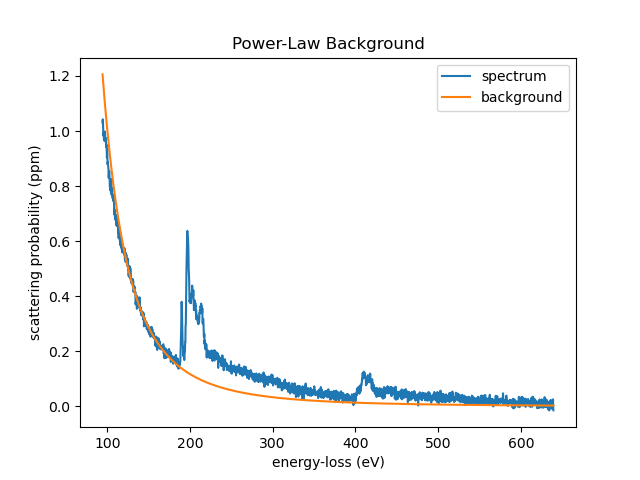

In [82]:
from scipy.optimize import leastsq  ## leastsqure fitting routine fo scipy


# Determine energy window in pixels
bgdStart = 130
bgdWidth = 40
energy_scale = spectrum.energy_loss
offset = energy_scale[0]
dispersion = energy_scale[1]-energy_scale[0]
startx = int((bgdStart-offset)/dispersion)
endx = startx + int(bgdWidth/dispersion) 

x = np.array(energy_scale[startx:endx])
y = np.array(spectrum[startx:endx])

# Initial values of parameters
p0 = np.array([1.0E+20,3])

## background fitting 
def bgdfit(p, y, x):
    err = y - (p[0]* np.power(x,(-p[1])))
    return err
p, lsq = leastsq(bgdfit, p0, args=(y, x), maxfev=2000)
print(f'Power-law background with amplitude A: {p[0]:.1f} and exponent -r: {p[1]:.2f}')

#Calculate background over the whole energy scale
background = p[0]* np.power(energy_scale,(-p[1]))

plt.figure()
plt.plot(spectrum.energy_loss, spectrum, label='spectrum')
plt.plot(spectrum.energy_loss, background, label='background')
plt.xlabel('energy-loss (eV)')
plt.ylabel('scattering probability (ppm)')
plt.title('Power-Law Background')
plt.legend();


## Fitting a Spectrum

We are revisiting the above the fundamental equation of the chemical composition:

We already calibrated the cross section in per $nm^2$ and so if we start again from the fundamental equation:

\begin{equation}
I_{edge}(\beta, \Delta E) = N I_{0}(\beta) \sigma_{edge}(\beta, \Delta E)
\end{equation}

and as above we calibrate the intensity of the spectrum by $I_{spectrum}/I_0$ then we get::

\begin{equation}
\frac{I_{edge}(\beta, \Delta E)}{I_0} = I^{norm}_{edge}  = N \sigma_{edge}(\beta, \Delta E)
\end{equation}

and if we fit the calibrated intensity with the cross section then we can replace$I^{norm}_{edge}$ by a fitting value $q_{edge}$ multiplied by cross section $\sigma$:


$$
N =  \frac{I_{edge}(\beta, \Delta E)/I_0}{\sigma_{edge}(\beta, \Delta E)}  = \frac{I^{norm}_{edge}}{\sigma_{edge}(\beta, \Delta E)} = \frac{q_{edge} * \sigma_{edge}(\beta, \Delta E)}{\sigma_{edge}(\beta, \Delta E)} = q_{edge}
$$ 

and N is in atoms per nm$^2$.

So a fit to a callibrated spectrum as above, will get us a ``fitting parameter`` which is an ``areal density`` (which is a legitimate thermodynamic quantity).

And for the relative composition we get:
$$
\frac{N_a}{N_b}= \frac{q_a}{q_b}
$$

In the following we will do this kind of a fit by:
- calibrate the intensity in the spectrum (in ppm)
- using  cross section in units of nm$^2$


>
> Please note that for the relative composition , the $I_0$ will fall out and so a fit to a spectrum without calibrated intensity will still give the relative intensity accurately.
>

### Preparing the fitting mask

Our theoretical cross sections do not include any solid state effects (band structure) and so the fine structure at the onset of the spectra must be omitted in a quantification.

These parts of the spectrum will be simply set to zero. We plot the masked spectrum that will be evaluated.

{'filename': 'B.K1', 'excl before': 5, 'excl after': 50, 'onset': 188.0, 'factor': 1.0, 'shape': 'hydrogenic'}
{'filename': 'N.K1', 'excl before': 5, 'excl after': 50, 'onset': 401.6, 'factor': 1.0, 'shape': 'hydrogenic'}


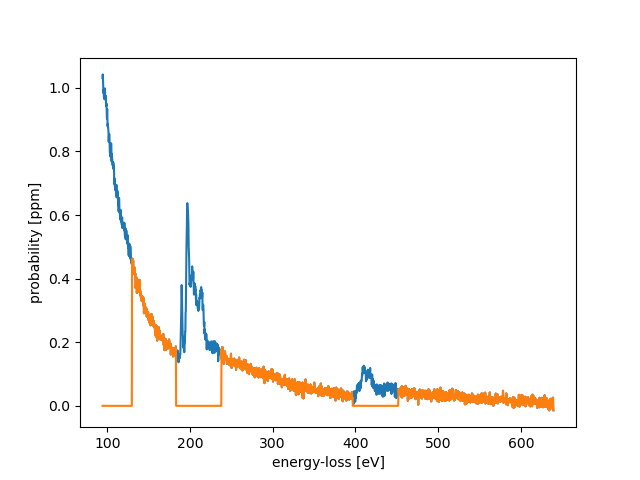

In [109]:
energy_scale = spectrum.energy_loss

dispersion = (energy_scale[1] - energy_scale[0])
offset = energy_scale[0]
startx = int((bgdStart-offset)/dispersion)

mask = np.ones(len(energy_scale))
mask[0 : int(startx)] = 0.0;

edges = {}
edges['1'] = {}
edges['1']['Z']=5
edges['1']['symmetry']= 'K1'
edges['2'] = {}
edges['2']['Z']=7
edges['2']['symmetry']= 'K1'

for key in edges:
    print((eels.get_x_sections(edges[key]['Z']))[edges[key]['symmetry']])
    edges[key]['onset'] = (eels.get_x_sections(edges[key]['Z']))[edges[key]['symmetry']]['onset']
    edges[key]['start_exclude'] = edges[key]['onset']-5 
    edges[key]['end_exclude']   = edges[key]['onset']+50
    edges[key]['data'] = eels.get_x_sections(edges[key]['Z'])
    mask[np.searchsorted(energy_scale, edges[key]['start_exclude']):np.searchsorted(energy_scale, edges[key]['end_exclude'])] = 0.0


plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale, spectrum*mask, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

### The Fit

The function **model** just sums the weighted cross-sections and the background.

The background consists of the power-lawbackground before plus a polynomial component allowing for *a variation of the exponent $r$ of the power-law*.

The least square fit is weighted by the noise according to Poison statistic $\sqrt{I(\Delta E)}$.

>
>Please note that the cross sections are for single atoms only and do not cover any solid state effects vsible as strong peaks in the first 50 eV or so past the onset.
>
> We exclude those parts from the fits.

1
2


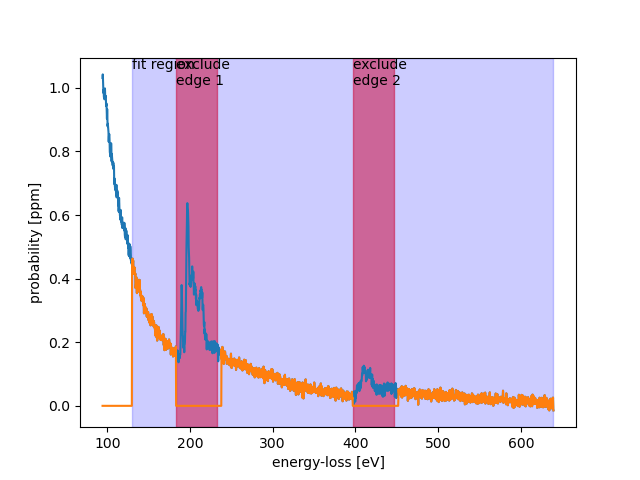

In [110]:
plt.figure()
plt.plot(energy_scale, spectrum, label='spectrum')
plt.plot(energy_scale, spectrum*mask, label='spectrum')
plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]');  

regions = ieels.RegionSelector(plt.gca())

for key in edges:
    print(key)
    regions.set_regions(str(key),edges[key]['onset']-5, 50.)
                                  
regions.set_regions('fit region',bgdStart, energy_scale[-1]-bgdStart)

In [111]:
region_tags = regions.get_regions()

mask = np.ones(main_dataset.shape)

#startx = np.searchsorted(tags['energy_scale'],region_tags['fit_area']['start_x'])
                            
mask[0:startx] = 0.0

for key in region_tags:
    end = region_tags[key]['start_x']+region_tags[key]['width_x']
    startx = np.searchsorted(energy_scale,region_tags[key]['start_x'])
    endx   = np.searchsorted(energy_scale,end)
    if key == 'fit_area':
        mask[0:startx] = 0.0
        mask[endx:-1] = 0.0
    else:
        mask[startx:endx] = 0.0



pin = np.array([1.,1.,.0,0.0,0.0,0.0, 1.0,1.0,0.001,5,3])
x = energy_scale

blurred = gaussian_filter(spectrum, sigma=5)

y = blurred*1e-6/dispersion ## now in probability
y[np.where(y<1e-8)]=1e-8


B_Xsection = eels.xsec_xrpa(energy_scale, 200, 5,  10. )/1e10  
N_Xsection = eels.xsec_xrpa(energy_scale, 200, 7,  10. )/1e10       #  xsec  is in barns = 10^-28 m2 = 10^-10 nm2

xsec = np.array([B_Xsection, N_Xsection])
numberOfEdges = 2

def residuals(p,  x, y ):
    err = (y-model(x,p))*mask/np.sqrt(np.abs(y))
    return err        

def model(x, p):  
    y = (p[9]* np.power(x,(-p[10]))) +p[7]*x+p[8]*x*x
    for i in range(numberOfEdges):
        y = y + p[i] * xsec[i,:]
    return y

p, cov = leastsq(residuals, pin,  args = (x,y) )
 
print(f"B/N ratio is {p[0]/p[1]:.3f}")

#the B atom areal density of a single layer of h-BN (18.2 nm−2) 
print(f" B areal density is {p[0]:.0f} atoms per square nm, which equates {abs(p[0])/18.2:.1f} atomic layers")
print(f" N areal density is {p[1]:.0f} atoms per square nm, which equates {abs(p[1])/18.2:.1f} atomic layers")

B/N ratio is 0.964
 B areal density is 122 atoms per square nm, which equates 6.7 atomic layers
 N areal density is 127 atoms per square nm, which equates 7.0 atomic layers


In [112]:
region_tags = regions.get_regions()

mask = np.ones(main_dataset.shape)

#startx = np.searchsorted(tags['energy_scale'],region_tags['fit_area']['start_x'])
                            
mask[0:startx] = 0.0

for key in region_tags:
    end = region_tags[key]['start_x']+region_tags[key]['width_x']
    startx = np.searchsorted(energy_scale,region_tags[key]['start_x'])
    endx   = np.searchsorted(energy_scale,end)
    if key == 'fit_area':
        mask[0:startx] = 0.0
        mask[endx:-1] = 0.0
    else:
        mask[startx:endx] = 0.0



pin = np.array([1e12,1e12,.0,0.0,0.0,0.0, 1.0,1.0,0.001,5,3])
x = energy_scale

blurred = gaussian_filter(spectrum, sigma=5)

y = blurred * (I0*1e-6)/dispersion ## now in counts
y[np.where(y<1e-8)]=1e-8


B_Xsection = eels.xsec_xrpa(energy_scale, 60, 5,  40. )/1e10  
N_Xsection = eels.xsec_xrpa(energy_scale, 60, 7,  40. )/1e10       #  xsec  is in barns = 10^-28 m2 = 10^-10 nm2

xsec = np.array([B_Xsection, N_Xsection])
numberOfEdges = 2

def residuals(p,  x, y ):
    err = (y-model(x,p))*mask/np.sqrt(np.abs(y))
    return err        

def model(x, p):  
    y = (p[9]* np.power(x,(-p[10]))) +p[7]*x+p[8]*x*x
    for i in range(numberOfEdges):
        y = y + p[i] * xsec[i,:]
    return y

p, cov = leastsq(residuals, pin,  args = (x,y) )
 
print(f'The multipliers of X-sections are: {p[0]:.2E}, {p[1]:.2E}')
print(f"B/N ratio is {p[0]/p[1]:.3f}")
#the B atom areal density of a single layer of h-BN (18.2 nm−2) 
print(f" B areal density is {p[0]/I0:.0f} atoms per square nm, which equates {abs(p[0]/I0)/18.2:.1f} atomic layers")
print(f" N areal density is {p[1]/I0:.0f} atoms per square nm, which equates {abs(p[1]/I0)/18.2:.1f} atomic layers")

C:\Users\gduscher\AppData\Local\Temp\ipykernel_34984\561077839.py:41: RuntimeWarning: overflow encountered in power
  y = (p[9]* np.power(x,(-p[10]))) +p[7]*x+p[8]*x*x
C:\Users\gduscher\AppData\Local\Temp\ipykernel_34984\561077839.py:37: RuntimeWarning: invalid value encountered in multiply
  err = (y-model(x,p))*mask/np.sqrt(np.abs(y))


The multipliers of X-sections are: 1.63E+12, 1.68E+12
B/N ratio is 0.972
 B areal density is 47 atoms per square nm, which equates 2.6 atomic layers
 N areal density is 48 atoms per square nm, which equates 2.7 atomic layers


C:\Users\gduscher\AppData\Local\Temp\ipykernel_34984\561077839.py:46: RuntimeWarning: Number of calls to function has reached maxfev = 2400.
  p, cov = leastsq(residuals, pin,  args = (x,y) )


###  Plotting of the fit


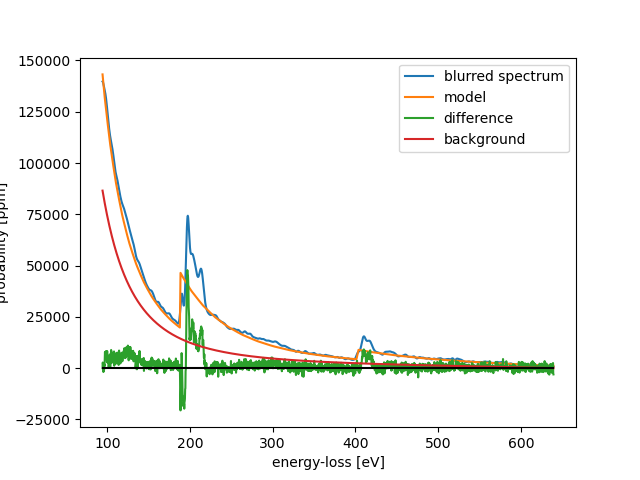

In [114]:
model_spectrum =  model(x, p) # in ppm
model_background =  ((p[9]* np.power(x,-p[10])) +p[7]*x+p[8]*x*x) # in ppm

plt.figure()
#plt.plot(energy_scale, spectrum* (I0*1e-6)/0.25, label='spectrum')
plt.plot(energy_scale, blurred* (I0*1e-6)/0.25, label='blurred spectrum')
plt.plot(x,model_spectrum, label='model')
plt.plot(x,main_dataset-model_spectrum, label='difference')


plt.plot(x,model_background, label='background')
plt.plot([x[0],x[-1]],[0,0],c='black')

plt.xlabel('energy-loss [eV]')
plt.ylabel('probability [ppm]')
plt.legend();

## Summary

We use a cross section in unsits of nm$^2$ and a calibrated spectrum to fit a cross section to each edge.

The fitting parameter is then the areal density of the element.

We only fit the part of the spectrum we know which is the single atom part of the edge, and avoid to fit any solid state effects at the onset of the edge.

The interpreation of solid state effects at the onset are discussed in the [energy-loss near-edge structure (ELNES)](./CH4_10-ELNES.ipynb) notebook.
